In [247]:
import dataclasses
from abc import ABC, abstractmethod
from typing import Any, List, Optional, Union, Literal
import xarray as xr
import numpy as np
import dacite
from scores.continuous import mae, rmse
import polars as pl
import pandas as pd
from extremeweatherbench import case, metrics, utils
import copy
from scipy.ndimage import gaussian_filter

# Notes

1. An easy? solution to dealing with variable mapping:
    - Create a list of the names of each variable used in EWB that users can extend
    - Each Observation should have a default mapping; if it's our observation default we will know the variable names coming in. Users will need to know the names of theirs as well.
    - Forecasts will be able to access this mapping as well and can be provided in the ExtremeWeatherBench call
2. ~~AppliedMetrics will define exactly what observations, observation variables, and forecast variables to use~~
    - I think this is wrong now, it should be defined at the Event level.
3. Defining the order of orchestration is still an open question. I guess this will come as I wire the components together... We're running each case as its own entity, thus:
    - Each case will have multiple metrics that might or might not reuse Observations and Forecasts. Do metrics inside cases define the variables and DerivedVariables? Or should the EventType? Leaning towards EventType. DerivedVariables hold information on what core variables are needed.
        1. Observation(s) should be built first which defines the dimensions for Forecasts.
        2. Observation(s) derived variables should be processed next.
        3. Forecasts should then be spatiotemporally subset to the Observation(s).
        4. Forecasts derived variables should then be processed.
        5. Might be worth then temporally subsetting the Observation(s) to the Forecasts
        6. Finally, run applied metrics that use the Observation(s) and Forecasts.


# Misc:

In [248]:
def convert_longitude_to_180(longitude: float) -> float:
    """Convert longitude from 0-360 to -180-180 degrees."""
    return (longitude + 180) % 360 - 180

@dataclasses.dataclass
class LocationCoords:
    latitude: xr.DataArray
    longitude: xr.DataArray

def practically_perfect_hindcast(
    ds: xr.Dataset,
    output_bounds: utils.Region,
    resolution: float = 0.25,
    report_type: Union[Literal["all"], list[Literal["tor", "hail", "wind"]]] = "all",
    sigma: float = 1.5,
) -> xr.Dataset:
    """Compute the Practically Perfect Hindcast (PPH) using storm report data using latitude/longitude grid spacing
    instead of the NCEP 212 Eta Lambert Conformal projection; based on the method described in Hitchens et al 2013,
    https://doi.org/10.1175/WAF-D-12-00113.1

    Args:
        ds: An xarray Dataset containing the storm report data.
        output_interpolation: A LocationCoords object containing the latitude and longitude of the output interpolation.
        resolution: The resolution of the grid to use. Default is 0.25 degrees.
        report_type: The type of report to use. Default is all. Currently only supports all.
        sigma: The sigma (standard deviation) of the gaussian filter to use. Default is 1.5.
    Returns:
        pph: An xarray DataArray containing the PPH around the storm report data.
    """
    if report_type != "all":
        ds = ds.where(ds['report_type'].isin(report_type))
    ds['longitude'] = utils.convert_longitude_to_360(ds['longitude'])
    # Create coordinates fixed at 0.25 degree intervals
    min_lat_fixed = np.ceil(output_bounds.latitude_min * 4) / 4  # Round up to nearest 0.25
    max_lat_fixed = np.floor(output_bounds.latitude_max * 4) / 4  # Round down to nearest 0.25
    min_lon_fixed = np.ceil(output_bounds.longitude_min * 4) / 4  # Round up to nearest 0.25
    max_lon_fixed = np.floor(output_bounds.longitude_max * 4) / 4  # Round down to nearest 0.25

    # Create the grid coordinates
    grid_lats = np.arange(min_lat_fixed, max_lat_fixed + resolution, resolution)
    grid_lons = np.arange(min_lon_fixed, max_lon_fixed + resolution, resolution)

    output_interpolation = LocationCoords(
        latitude=xr.DataArray(
            grid_lats,
            dims=["latitude"]
        ),
        longitude=xr.DataArray(
            grid_lons,
            dims=["longitude"]
        )
    )
    # Initialize an empty grid
    grid = np.zeros((len(grid_lats), len(grid_lons)))

    report_lats = ds['latitude'].values
    report_lons = ds['longitude'].values

    # Mark grid cells that contain reports
    for lat, lon in zip(report_lats, report_lons):
        # Find the nearest grid indices
        lat_idx = np.abs(grid_lats - lat).argmin()
        lon_idx = np.abs(grid_lons - lon).argmin()
        grid[lat_idx, lon_idx] = 1

    # Create the xarray DataArray
    pph_ds = xr.Dataset(
        data_vars={"reports": (["latitude", "longitude"], grid)},
        coords={"latitude": grid_lats, "longitude": grid_lons},
    )

    # Apply bilinear interpolation to smooth the field
    # First, create a gaussian kernel for smoothing
    smoothed_grid = gaussian_filter(grid, sigma=sigma)

    # Combine the data into a Dataset
    pph_ds['practically_perfect'] = xr.DataArray(smoothed_grid, dims=["latitude", "longitude"])

    return pph_ds


# EWB Variable Names

In [249]:
EWB_VARIABLES = {
    'data_vars': 
                 [
                     'surface_air_temperature',
                     'air_pressure_at_mean_sea_level',
                     'surface_air_pressure',
                     'surface_wind_speed',
                     'surface_wind_from_direction',
                     'surface_air_temperature',
                     'surface_dew_point_temperature',
                     'surface_relative_humidity',
                     'accumulated_1_hour_precipitation',
                     'pressure_level',
                     'air_temperature',
                     'dewpoint_temperature',
                     'relative_humidity',
                     'specific_humidity',
                     'geopotential',
                     'geopotential_height',
                     'potential_temperature',
                     'vertical_velocity',
                     'eastward_wind',
                     'northward_wind',
                     ],
                     'coords': [
                 'valid_time',
                 'init_time',
                 'lead_time',
                 'latitude',
                 'longitude',
                 'elevation',
                 'station_id',
                 'station_long_name',
                 'case_id'
                 ]
                 }

# DerivedVariables

In [250]:
class DerivedVariable(ABC):
    """A base class defining the interface for ExtremeWeatherBench derived variables.
    
    A DerivedVariable is any variable that requires extra computation, not derived in an
    observation or forecast raw dataset. Some examples include the practically perfect hindcast,
    MLCAPE, IVT, or atmospheric river masks.
    
    Attributes:
        name: The name of the variable.
        input_variables: A list of variables that are used to compute the variable.
    """

    def __init__(self, name: str, input_variables: List[str]):
        self._name = name
        self._input_variables = input_variables

    @property
    def name(self) -> str:
        """Get the name of the variable."""
        return self._name

    @property
    def input_variables(self) -> List[str]:
        """Get the input variables for the variable."""
        return self._input_variables

    def _check_variables(self, data: xr.Dataset, variables: Optional[List[str]] = None) -> List[str]:
        """Check that the variables are in the dataset."""
        if variables is None:
            variables = list(data.data_vars)
        for variable in variables:
            if variable not in data.data_vars:
                raise ValueError(f"Variable {variable} not found in dataset.")

    @abstractmethod
    def compute(self, case: case.IndividualCase, data: xr.Dataset, variables: Optional[List[str]] = None) -> xr.Dataset:
        """Compute the variable from the input variables."""


class PracticallyPerfectHindcast(DerivedVariable):
    """A derived variable that computes the practically perfect hindcast."""

    def __init__(self):
        super().__init__(name = "practically_perfect_hindcast", input_variables = ['report_type'])

    def compute(self, single_case: case.IndividualCase, data: xr.Dataset, variables: Optional[List[str]] = None) -> xr.Dataset:
        """Compute the practically perfect hindcast."""
        pph = practically_perfect_hindcast(data[self.input_variables], output_bounds = single_case.location, report_type = ['tor', 'hail'])
        return pph
    
class CravenSignificantSevereParameter(DerivedVariable):
    """A derived variable that computes the Craven significant severe parameter."""

    def __init__(self):
        super().__init__(
            name = "craven_significant_severe_parameter", 
            input_variables = ['air_temperature', 
                               'dewpoint_temperature',
                               'relative_humidity',
                               'eastward_wind',
                               'northward_wind',
                               'surface_eastward_wind',
                               'surface_northward_wind'])

    def compute(self, case: case.IndividualCase, data: xr.Dataset, variables: Optional[List[str]] = None) -> xr.Dataset:
        """Compute the Craven significant severe parameter."""
        cbss_ds = calc.craven_brooks_significant_severe(
            case, data[self.input_variables])
        return data
    

# Observations:

In [251]:
#: Storage/access options for gridded observation datasets.
ARCO_ERA5_FULL_URI = (
    "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3"
)

#: Storage/access options for default point observation dataset.
DEFAULT_GHCN_URI = "gs://extremeweatherbench/datasets/ghcnh.parq"

#: Storage/access options for local storm report (LSR) tabular data.
LSR_URI = "gs://extremeweatherbench/datasets/lsr_01012020_04302025.parq"

IBTRACS_URI = "https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/csv/ibtracs.ALL.list.v04r01.csv"  # noqa: E501

# type hint for the data input to the observation classes
ObservationDataInput = Union[
    xr.Dataset, xr.DataArray, pl.LazyFrame, pd.DataFrame, np.ndarray
]


class Observation(ABC):
    """
    Abstract base class for all observation types.

    An Observation is data that acts as the "truth" for a case. It can be a gridded dataset,
    a point observation dataset, or any other reference dataset. Observations in EWB
    are not required to be the same variable as the forecast dataset, but they must be in the
    same coordinate system for evaluation.
    """

    source: str

    @abstractmethod
    def _open_data_from_source(
        self, storage_options: Optional[dict] = None
    ) -> ObservationDataInput:
        """
        Open the observation data from the source, opting to avoid loading the entire dataset into memory if possible.

        Args:
            source: The source of the observation data, which can be a local path or a remote URL.
            storage_options: Optional storage options for the source if the source is a remote URL.

        Returns:
            The observation data with a type determined by the user.
        """

    @abstractmethod
    def _subset_data_to_case(
        self,
        data: ObservationDataInput,
        case: case.IndividualCase,
        variables: Optional[list[str]] = None,
    ) -> ObservationDataInput:
        """
        Subset the observation data to the case information provided in IndividualCase.

        Time information, spatial bounds, and variables are captured in the case metadata
        where this method is used to subset.

        Args:
            data: The observation data to subset, which should be a xarray dataset, xarray dataarray, polars lazyframe,
            pandas dataframe, or numpy array.
            variables: The variables to include in the observation. Some observations may not have variables, or
            only have a singular variable; thus, this is optional.

        Returns:
            The observation data with the variables subset to the case metadata.
        """

    @abstractmethod
    def _maybe_convert_to_dataset(self, data: ObservationDataInput) -> xr.Dataset:
        """
        Convert the observation data to an xarray dataset if it is not already.

        If this method is used prior to _subset_data_to_case, OOM errors are possible
        prior to subsetting.

        Args:
            data: The observation data already run through _subset_data_to_case.

        Returns:
            The observation data as an xarray dataset.
        """

    def _maybe_derive_variables(
        self, data: xr.Dataset, case: case.IndividualCase, variables: list[str | DerivedVariable]
    ) -> xr.Dataset:
        """
        Derive variables from the observation data if any exist in variables.

        Args:
            data: The observation data already run through _subset_data_to_case.
            variables: The variables to derive.

        Returns:
            The observation data with the derived variables.
        """

        for v in variables:
            # there should only be strings or derived variables in the list
            if not isinstance(v, str):
                if not issubclass(v, DerivedVariable):
                    raise ValueError(f"Expected str or DerivedVariable, got {type(v)}")
                derived_data = v().compute(data=data, single_case=case, variables=variables)
                return derived_data
        return data

    def run_pipeline(
        self,
        case: case.IndividualCase,
        storage_options: Optional[dict] = None,
        variables: Optional[list[str | DerivedVariable]] = None,
    ) -> xr.Dataset:
        """
        Shared method for running the observation pipeline.

        Args:
            source: The source of the observation data, which can be a local path or a remote URL.
            storage_options: Optional storage options for the source if the source is a remote URL.
            variables: The variables to include in the observation. Some observations may not have variables, or
            only have a singular variable; thus, this is optional.

        Returns:
            The observation data with a type determined by the user.
        """

        # Open data and process through pipeline steps
        data = (
            self._open_data_from_source(
                storage_options=storage_options,
            )
            .pipe(
                self._subset_data_to_case,
                case=case,
                variables=variables,
            )
            .pipe(self._maybe_convert_to_dataset)
            .pipe(self._maybe_derive_variables, case=case, variables=variables or [])
        )
        return data


class ERA5(Observation):
    """
    Observation class for ERA5 gridded data.

    The easiest approach to using this class
    is to use the ARCO ERA5 dataset provided by Google for a source. Otherwise, either a
    different zarr source or modifying the _open_data_from_source method to open the data
    using another method is required.
    """

    source: str = ARCO_ERA5_FULL_URI

    def _open_data_from_source(
        self, storage_options: Optional[dict] = None
    ) -> ObservationDataInput:
        data = xr.open_zarr(
            self.source,
            chunks=None,
            storage_options=dict(token="anon"),
        )
        return data

    def _subset_data_to_case(
        self,
        data: ObservationDataInput,
        case: case.IndividualCase,
        variables: Optional[list[str]] = None,
    ) -> ObservationDataInput:

        if not isinstance(data, (xr.Dataset, xr.DataArray)):
            raise ValueError(f"Expected xarray Dataset or DataArray, got {type(data)}")

        subset_data = data.sel(
            time=slice(case.start_date, case.end_date),
            # latitudes are sliced from max to min
            latitude=slice(case.location.latitude_max, case.location.latitude_min),
            longitude=slice(case.location.longitude_min, case.location.longitude_max),
        )

        # check that the variables are in the observation data
        if variables is not None and any(
            var not in subset_data.data_vars for var in variables
        ):
            raise ValueError(f"Variables {variables} not found in observation data")

        # subset the variables
        if variables is not None:
            subset_data = subset_data[variables]

        return subset_data

    def _maybe_convert_to_dataset(self, data: ObservationDataInput):
        if isinstance(data, xr.DataArray):
            data = data.to_dataset()
        return data


class GHCN(Observation):
    """
    Observation class for GHCN tabular data.

    Data is processed using polars to maintain the lazy loading
    paradigm in _open_data_from_source and to separate the subsetting
    into _subset_data_to_case.
    """

    source: str = DEFAULT_GHCN_URI

    def _open_data_from_source(
        self, storage_options: Optional[dict] = None
    ) -> ObservationDataInput:
        observation_data: pl.LazyFrame = pl.scan_parquet(
            self.source, storage_options=storage_options
        )

        return observation_data

    def _subset_data_to_case(
        self,
        observation_data: ObservationDataInput,
        case: case.IndividualCase,
        variables: Optional[list[str]] = None,
    ) -> ObservationDataInput:
        # Create filter expressions for LazyFrame
        time_min = case.start_date - pd.Timedelta(days=2)
        time_max = case.end_date + pd.Timedelta(days=2)

        if not isinstance(observation_data, pl.LazyFrame):
            raise ValueError(f"Expected polars LazyFrame, got {type(observation_data)}")

        # Apply filters using proper polars expressions
        subset_observation_data = observation_data.filter(
            (pl.col("time") >= time_min)
            & (pl.col("time") <= time_max)
            & (pl.col("latitude") >= case.location.latitude_min)
            & (pl.col("latitude") <= case.location.latitude_max)
            & (pl.col("longitude") >= case.location.longitude_min)
            & (pl.col("longitude") <= case.location.longitude_max)
        )

        # Add time, latitude, and longitude to the variables, polars doesn't do indexes
        if variables is None:
            all_variables = ["time", "latitude", "longitude"]
        else:
            all_variables = variables + ["time", "latitude", "longitude"]

        # check that the variables are in the observation data
        schema_fields = [field for field in subset_observation_data.collect_schema()]
        if variables is not None and any(
            var not in schema_fields for var in all_variables
        ):
            raise ValueError(f"Variables {all_variables} not found in observation data")

        # subset the variables
        if variables is not None:
            subset_observation_data = subset_observation_data.select(all_variables)

        return subset_observation_data

    def _maybe_convert_to_dataset(self, data: ObservationDataInput):
        if isinstance(data, pl.LazyFrame):
            data = data.collect().to_pandas()
            data = data.set_index(["time", "latitude", "longitude"])
            # GHCN data can have duplicate values right now, dropping here if it occurs
            try:
                data = data.to_xarray()
            except ValueError as e:
                if "non-unique" in str(e):
                    pass
                data = data.drop_duplicates().to_xarray()
            return data
        else:
            raise ValueError(f"Data is not a polars LazyFrame: {type(data)}")


class LSR(Observation):
    """
    Observation class for local storm report (LSR) tabular data.

    run_pipeline() returns a dataset with LSRs and practically perfect hindcast gridded
    probability data. IndividualCase date ranges for LSRs should ideally be
    12 UTC to the next day at 12 UTC to match SPC methods.
    """

    source: str = LSR_URI

    def _open_data_from_source(
        self, storage_options: Optional[dict] = None
    ) -> ObservationDataInput:
        
        # force LSR to use anon token to prevent google reauth issues for users
        observation_data = pd.read_parquet(self.source, storage_options={'token': 'anon'})

        return observation_data

    def _subset_data_to_case(
        self,
        observation_data: ObservationDataInput,
        case: case.IndividualCase,
        variables: Optional[list[str]] = None,
    ) -> ObservationDataInput:
        if not isinstance(observation_data, pd.DataFrame):
            raise ValueError(f"Expected pandas DataFrame, got {type(observation_data)}")

        # latitude, longitude are strings by default, convert to float
        observation_data["lat"] = observation_data["lat"].astype(float)
        observation_data["lon"] = observation_data["lon"].astype(float)
        observation_data["time"] = pd.to_datetime(observation_data["time"])

        filters = (
            (observation_data["time"] >= case.start_date)
            & (observation_data["time"] <= case.end_date)
            & (observation_data["lat"] >= case.location.latitude_min)
            & (observation_data["lat"] <= case.location.latitude_max)
            & (observation_data["lon"] >= convert_longitude_to_180(case.location.longitude_min))
            & (observation_data["lon"] <= convert_longitude_to_180(case.location.longitude_max))
        )

        subset_observation_data = observation_data.loc[filters]

        subset_observation_data = subset_observation_data.rename(
            columns={"lat": "latitude", "lon": "longitude", "time": "valid_time"}
        )

        return subset_observation_data

    def _maybe_convert_to_dataset(self, data: ObservationDataInput):
        if isinstance(data, pd.DataFrame):
            data = data.set_index(["valid_time", "latitude", "longitude"])
            try:
                data = data.to_xarray()
            except ValueError as e:
                if "non-unique" in str(e):
                    pass
                data = data.drop_duplicates().to_xarray()
            return data
        else:
            raise ValueError(f"Data is not a pandas DataFrame: {type(data)}")


class IBTrACS(Observation):
    """
    Observation class for IBTrACS data.
    """

    source: str = IBTRACS_URI

    def _open_data_from_source(
        self, storage_options: Optional[dict] = None
    ) -> ObservationDataInput:
        # not using storage_options in this case due to NetCDF4Backend not supporting them
        observation_data: pl.LazyFrame = pl.scan_csv(
            self.source, storage_options=storage_options
        )
        return observation_data

    def _subset_data_to_case(
        self,
        observation_data: ObservationDataInput,
        case: case.IndividualCase,
        variables: Optional[list[str]] = None,
    ) -> ObservationDataInput:
        # Create filter expressions for LazyFrame
        year = case.start_date.year

        if not isinstance(observation_data, pl.LazyFrame):
            raise ValueError(f"Expected polars LazyFrame, got {type(observation_data)}")

        # Apply filters using proper polars expressions
        subset_observation_data = observation_data.filter(
            (pl.col("NAME") == case.title.upper())
        )

        all_variables = [
            "SEASON",
            "NUMBER",
            "NAME",
            "ISO_TIME",
            "LAT",
            "LON",
            "WMO_WIND",
            "USA_WIND",
            "WMO_PRES",
            "USA_PRES",
        ]
        # Get the season (year) from the case start date, cast as string as polars is interpreting the schema as strings
        season = str(year)

        # First filter by name to get the storm data
        subset_observation_data = observation_data.filter(
            (pl.col("NAME") == case.title.upper())
        )

        # Create a subquery to find all storm numbers in the same season
        matching_numbers = (
            subset_observation_data.filter(pl.col("SEASON") == season)
            .select("NUMBER")
            .unique()
        )

        # Apply the filter to get all data for storms with the same number in the same season
        # This maintains the lazy evaluation
        subset_observation_data = observation_data.join(
            matching_numbers, on="NUMBER", how="inner"
        ).filter((pl.col("NAME") == case.title.upper()) & (pl.col("SEASON") == season))

        # check that the variables are in the observation data
        schema_fields = [field for field in subset_observation_data.collect_schema()]
        if variables is not None and any(
            var not in schema_fields for var in all_variables
        ):
            raise ValueError(f"Variables {all_variables} not found in observation data")

        # subset the variables
        if variables is not None:
            subset_observation_data = subset_observation_data.select(all_variables)

        return subset_observation_data

    def _maybe_convert_to_dataset(self, data: ObservationDataInput):
        if isinstance(data, pl.LazyFrame):
            data = data.collect().to_pandas()
            data = data.set_index(["ISO_TIME"])
            try:
                data = data.to_xarray()
            except ValueError as e:
                if "non-unique" in str(e):
                    pass
                data = data.drop_duplicates().to_xarray()
            return data
        else:
            raise ValueError(f"Data is not a polars LazyFrame: {type(data)}")


# Cases:

In [252]:
#TODO implement this in case.py
@dataclasses.dataclass
class BaseCaseMetadataCollection:
    cases: List[case.IndividualCase]

    def subset_cases_by_event_type(self, event_type: str) -> List[case.IndividualCase]:
        """Subset the cases in the collection by event type."""
        return [c for c in self.cases if c.event_type == event_type]

In [253]:
@dataclasses.dataclass
class CaseOperator:
    """A class which stores the graph to process an individual case."""
    
    case: case.IndividualCase
    metrics: list[metrics.Metric]
    observations: list[Observation]
    
    def evaluate_case(self, forecast: xr.Dataset):
        """Process a case."""
        self.process_metrics(forecast)
        
    def process_metrics(self, forecast: xr.Dataset):
        """Process the metrics."""
        for metric in self.metrics:
            metric.process_metric(forecast, self.observations)

    def build_observations(self) -> xr.Dataset:
        """Build observation xarray Datasets from the observation sources."""
        observation_datasets = []
        for observation in self.observation_sources:
            obs_dataset = observation.run_pipeline()
            observation_datasets.append(obs_dataset)
        
        # Combine all observation datasets into a single dataset
        if len(observation_datasets) >= 1:
            combined_obs = xr.merge(observation_datasets)
            return combined_obs
        else:
            raise ValueError("No observations provided or observations failed to run, check the observation sources.")

    

# Metrics:

It seems logical to split up simple metrics, e.g. MAE, and more complicated split-apply-combine or other methods that requires multiple steps to prepare for said simple metric. These more complicated metrics are "AppliedMetrics", and can optionally include the simple metrics. Some metrics part of EWB don't have a simple metric downstream, such as categorical thresholds and contingency table metrics. This is a bit of a WIP so will update as the orchestration becomes more clear.

In [254]:
class BaseMetric(ABC):
    @abstractmethod
    def compute(self, forecast: xr.Dataset, observation: xr.Dataset):
        pass

class AppliedMetric(ABC):
    def __init__(
            self, 
            metric: BaseMetric, 
            observation_sources: list[Observation],
            variables: list[str | DerivedVariable],
            
            ):
        self.metric = metric
        self.observation_sources = observation_sources
        self.variables = variables

    def compute_metric(self, forecast: xr.Dataset):
        return self.metric.compute(forecast, self.observation_sources)


class MAE(BaseMetric):

    def compute(self, forecast: xr.Dataset, observation: xr.Dataset, **kwargs):
        return mae(forecast, observation, **kwargs)

class RMSE(BaseMetric):
    def compute(self, forecast: xr.Dataset, observation: xr.Dataset, **kwargs):
        return rmse(forecast, observation, **kwargs)

class MaximumMAE(AppliedMetric):

    def __init__(self, metric: BaseMetric = MAE, observation: Observation = ERA5):
        super().__init__(metric, observation)

    def compute_metric(self, forecast: xr.Dataset, observation: xr.Dataset):
        maximum_timestep = observation.mean(["latitude", "longitude"]).idxmax("valid_time").values
        maximum_value = observation.mean(["latitude", "longitude"]).sel(valid_time=maximum_timestep).values
        forecast_spatial_mean = forecast.mean(["latitude", "longitude"])
        filtered_max_forecast = forecast_spatial_mean.mean(['latitude','longitude']).where(
            (forecast_spatial_mean.valid_time >= maximum_timestep - np.timedelta64(48, 'h')) & 
            (forecast_spatial_mean.valid_time <= maximum_timestep + np.timedelta64(48, 'h')),
            drop=True
        ).max('valid_time')
        return self.metric().compute(filtered_max_forecast, maximum_value)
    
class RegionalRMSE(AppliedMetric):
    def __init__(self, metric: BaseMetric = RMSE, observation: Observation = ERA5):
        super().__init__(metric, observation)

    def compute_metric(self, forecast: xr.Dataset, observation: xr.Dataset):
        return self.metric.compute(forecast, observation, preserve_dims='lead_time')
    
# Dummy metric classes for different event types

class MaxMinMAE(AppliedMetric):
    def __init__(self, metric: BaseMetric = MAE, observation: Observation = ERA5):
        super().__init__(metric, observation)

    def compute_metric(self, forecast: xr.Dataset, observation: xr.Dataset):
        # Dummy implementation for finding both max and min values
        return self.metric().compute(forecast, observation)

class OnsetME(AppliedMetric):
    def __init__(self, metric: BaseMetric = MAE, observation: Observation = ERA5):
        super().__init__(metric, observation)

    def compute_metric(self, forecast: xr.Dataset, observation: xr.Dataset):
        # Dummy implementation for onset mean error
        return self.metric().compute(forecast, observation)

class DurationME(AppliedMetric):
    def __init__(self, metric: BaseMetric = MAE, observation: Observation = ERA5):
        super().__init__(metric, observation)

    def compute_metric(self, forecast: xr.Dataset, observation: xr.Dataset):
        # Dummy implementation for duration mean error
        return self.metric().compute(forecast, observation)

class CSI(AppliedMetric):
    def __init__(self, metric: BaseMetric = MAE, observation: Observation = ERA5):
        super().__init__(metric, observation)

    def compute_metric(self, forecast: xr.Dataset, observation: xr.Dataset):
        # Dummy implementation for Critical Success Index
        return self.metric().compute(forecast, observation)

class LeadTimeDetection(AppliedMetric):
    def __init__(self, metric: BaseMetric = MAE, observation: Observation = ERA5):
        super().__init__(metric, observation)

    def compute_metric(self, forecast: xr.Dataset, observation: xr.Dataset):
        # Dummy implementation for lead time detection
        return self.metric().compute(forecast, observation)

class RegionalHitsMisses(AppliedMetric):
    def __init__(self, metric: BaseMetric = MAE, observation: Observation = ERA5):
        super().__init__(metric, observation)

    def compute_metric(self, forecast: xr.Dataset, observation: xr.Dataset):
        # Dummy implementation for regional hits and misses
        return self.metric().compute(forecast, observation)

class HitsMisses(AppliedMetric):
    def __init__(self, metric: BaseMetric = MAE, observation: Observation = ERA5):
        super().__init__(metric, observation)

    def compute_metric(self, forecast: xr.Dataset, observation: xr.Dataset):
        # Dummy implementation for hits and misses
        return self.metric().compute(forecast, observation)


# Events:

In [255]:
def maybe_expand_variable_lists(variable_list: List[str | DerivedVariable]) -> List[str]:
    """Build a list of core variables for the event, given the forecast and observation variables."""

    def iterator(variables: List[str | DerivedVariable]) -> List[str]:
        for variable in variables:
            if isinstance(variable, str):
                pass
            elif issubclass(variable, DerivedVariable):
                variables.extend([n for n in variable().input_variables])
        return variables

    return iterator(variable_list)

class EventType(ABC):
    """A base class defining the interface for ExtremeWeatherBench event types.

    An Event in ExtremeWeatherBench defines a specific weather event type, such as a heat wave,
    severe convective weather, or atmospheric rivers. These events encapsulate a set of cases and
    derived behavior for evaluating those cases. These cases will share common metrics, observations,
    and variables while each having unique dates and locations.

    Attributes:
        event_type: The type of event.
        forecast_variables: A list of variables that are used to forecast the event.
        observation_variables: A list of variables that are used to observe the event.
        case_metadata: A dictionary or yaml file with guiding metadata.
        metrics: A list of Metrics that are used to evaluate the cases.
        observations: A list of Observations that are used as targets for the metrics.
    """

    def __init__(
        self,
        event_type: str,
        forecast_variables: List[str | DerivedVariable],
        observation_variables: List[str | DerivedVariable],
        case_metadata: dict[str, Any],
        metrics: List[metrics.Metric],
        observations: List[Observation],
    ):
        self.event_type = event_type
        self.forecast_variables = maybe_expand_variable_lists(forecast_variables)
        self.observation_variables = maybe_expand_variable_lists(observation_variables)
        self.case_metadata = case_metadata
        self.metrics = metrics
        self.observations = observations

    def _build_base_case_metadata_collection(self) -> BaseCaseMetadataCollection:
        """Build a list of IndividualCases from the case_metadata."""
        cases = dacite.from_dict(
            data_class=BaseCaseMetadataCollection, 
            data=self.case_metadata, 
            config=dacite.Config(
                    type_hooks={utils.Region: utils.map_to_create_region},
                ),
        )
        cases = BaseCaseMetadataCollection(cases=[c for c in cases.cases if c.event_type == self.event_type])
        return cases
    
    def build_case_operator(self) -> list[CaseOperator]:
        """Build a CaseOperator from the event type."""
        case_metadata_collection = self._build_base_case_metadata_collection()
        case_operators = [
            CaseOperator(
                case = case,
                metrics = self.metrics,
                observations = self.observations,
                ) 
                for case in case_metadata_collection.cases
                ]
        return case_operators

class HeatWave(EventType):
    def __init__(self, case_metadata: dict[str, Any], 
                 forecast_variables: List[str | DerivedVariable] = ['surface_air_temperature'],
                 observation_variables: List[str | DerivedVariable] = ['surface_air_temperature'],
                 metrics: List[metrics.Metric] = [MaximumMAE,
                                                  MaxMinMAE, 
                                                  RegionalRMSE,
                                                  OnsetME,
                                                  DurationME], 
                 observations: List[Observation] = [ERA5]
                 ):
        super().__init__(event_type='heat_wave', 
                         forecast_variables=forecast_variables,
                         observation_variables=observation_variables,
                         case_metadata=case_metadata, 
                         metrics=metrics, 
                         observations=observations)

class SevereConvection(EventType):
    def __init__(self, case_metadata: dict[str, Any], 
                 forecast_variables: List[str | DerivedVariable] = [
                     CravenSignificantSevereParameter,
                 ],
                 observation_variables: List[str | DerivedVariable] = [
                     PracticallyPerfectHindcast,
                 ],
                 metrics: List[metrics.Metric] = [CSI, 
                                                  LeadTimeDetection, 
                                                  RegionalHitsMisses, 
                                                  HitsMisses
                                                  ], 
                 observations: List[Observation] = [LSR]
                 ):
        super().__init__(event_type='severe_convection',
                         forecast_variables=forecast_variables,
                         observation_variables=observation_variables,
                         case_metadata=case_metadata, 
                         metrics=metrics, 
                         observations=observations)

class AtmosphericRiver(EventType):
    def __init__(self, case_metadata: dict[str, Any], 
                 forecast_variables: List[str | DerivedVariable] = [],
                 observation_variables: List[str | DerivedVariable] = [],
                 metrics: List[metrics.Metric] = [CSI, 
                                                  LeadTimeDetection,
                                                  ], 
                 observations: List[Observation] = [ERA5]
                 ):
        super().__init__(event_type='atmospheric_river', 
                         forecast_variables=forecast_variables,
                         observation_variables=observation_variables,
                         case_metadata=case_metadata, 
                         metrics=metrics, 
                         observations=observations)

@dataclasses.dataclass    
class EventOperator:
    events: List[EventType]
    pre_composed_metrics: List[metrics.Metric] = dataclasses.field(default_factory=list, init=False, repr=True)
    pre_composed_observations: List[Observation] = dataclasses.field(default_factory=list, init=False, repr=True)
    pre_composed_forecast_variables: List[str | DerivedVariable] = dataclasses.field(default_factory=list, init=False, repr=True)
    pre_composed_observation_variables: List[str | DerivedVariable] = dataclasses.field(default_factory=list, init=False, repr=True)
    pre_composed_case_operators: List[CaseOperator] = dataclasses.field(default_factory=list, init=False, repr=True)
    
    def __post_init__(self):
        # Unravel attributes from composed event types
        self.pre_composed_metrics = []
        self.pre_composed_observations = []
        self.pre_composed_forecast_variables = []
        self.pre_composed_observation_variables = []
        self.pre_composed_case_operators = []
        
        # Collect attributes from each event type
        for event in self.events:
            self.pre_composed_metrics.extend(event.metrics)
            self.pre_composed_observations.extend(event.observations)
            self.pre_composed_forecast_variables.extend(event.forecast_variables)
            self.pre_composed_observation_variables.extend(event.observation_variables)
            self.pre_composed_case_operators.extend(event.build_case_operator())



# Orchestration

In [256]:
case_yaml = utils.read_event_yaml('/Users/taylor/code/ExtremeWeatherBench/src/extremeweatherbench/data/events.yaml')
heat_waves = HeatWave(case_metadata=case_yaml)

# Without using the EventOperator class
heat_waves.build_case_operator()

# With the EventOperator class
event_operator = EventOperator(events=[heat_waves])

severe_convection = SevereConvection(case_metadata=case_yaml)
total_event_operator = EventOperator(events=[severe_convection])

In [257]:
def _process_observations(case_operator: CaseOperator, variables: list[str | DerivedVariable], copy_data = True):
    observation_data_list = []
    if copy_data:
        modified_case_operator = copy.deepcopy(case_operator)
    else:
        modified_case_operator = case_operator
    for observation in modified_case_operator.observations:
        observation_data = observation().run_pipeline(case=modified_case_operator.case, variables=variables)
        observation_data_list.append(observation_data)
    return observation_data_list

class ExtremeWeatherBench:
    def __init__(self, event_operator: EventOperator, forecast_dir: str):
        self.event_operator = copy.deepcopy(event_operator)
        self.forecast_dir = forecast_dir

    def run(self):
        '''Runs the workflow'''
        for case_operator in self.event_operator.pre_composed_case_operators:
            self.process_case(case_operator)
        pass

    def process_case(self, case_operator: CaseOperator):
        observation_ds = self.process_observations(case_operator)
        return observation_ds

    def process_observations(self, case_operator: CaseOperator):
        pre_derived_observation_ds = _process_observations(case_operator, variables=self.event_operator.pre_composed_observation_variables)
        return pre_derived_observation_ds



forecast_dir = 'gs://extremeweatherbench/virtualizarr/fcn_v3.parq'
ewb = ExtremeWeatherBench(total_event_operator, forecast_dir)

In [258]:
ewb.event_operator.pre_composed_case_operators

[CaseOperator(case=IndividualCase(case_id_number=36, title='July 2024 South Dakota', start_date=datetime.datetime(2024, 7, 13, 0, 0), end_date=datetime.datetime(2024, 7, 14, 0, 0), location=BoundingBoxRegion(latitude_min=24.0, latitude_max=49.0, longitude_min=251.0, longitude_max=271.0), event_type='severe_convection', data_vars=None, cross_listed=None), metrics=[<class '__main__.CSI'>, <class '__main__.LeadTimeDetection'>, <class '__main__.RegionalHitsMisses'>, <class '__main__.HitsMisses'>], observations=[<class '__main__.LSR'>]),
 CaseOperator(case=IndividualCase(case_id_number=37, title='July 2024 Chicago', start_date=datetime.datetime(2024, 7, 14, 0, 0), end_date=datetime.datetime(2024, 7, 16, 0, 0), location=BoundingBoxRegion(latitude_min=24.0, latitude_max=49.0, longitude_min=251.0, longitude_max=271.0), event_type='severe_convection', data_vars=None, cross_listed=None), metrics=[<class '__main__.CSI'>, <class '__main__.LeadTimeDetection'>, <class '__main__.RegionalHitsMisses'>,

In [259]:
test_output = ewb.process_observations(ewb.event_operator.pre_composed_case_operators[0])

In [260]:
test_output[0].reports

<xarray.DataArray 'reports' (latitude: 101, longitude: 81)> Size: 65kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(101, 81))
Coordinates:
  * latitude   (latitude) float64 808B 24.0 24.25 24.5 24.75 ... 48.5 48.75 49.0
  * longitude  (longitude) float64 648B 251.0 251.2 251.5 ... 270.5 270.8 271.0

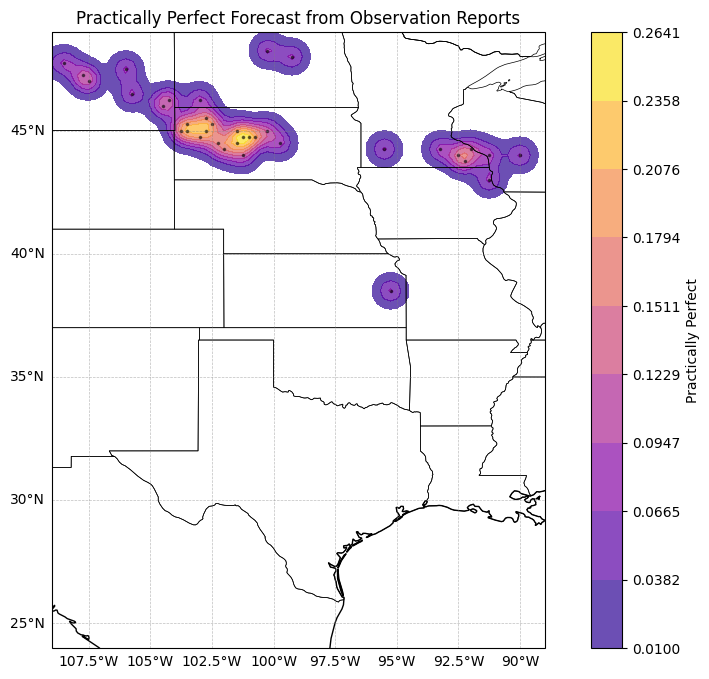

In [263]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from scipy.ndimage import gaussian_filter

# Create a figure and axis with a specific projection
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

# Get reports data
reports = test_output[0].reports

# Create practically perfect forecast from reports using Gaussian smoothing
# Convert reports to a numpy array for processing
reports_array = reports.values
sigma = 1.5  # Smoothing parameter - adjust as needed
practically_perfect = gaussian_filter(reports_array, sigma=sigma)

# Create contour plot of practically perfect forecast
contour_levels = np.linspace(0.01, practically_perfect.max(), 10)
contour = ax.contourf(reports.longitude, reports.latitude, practically_perfect, 
                     levels=contour_levels, cmap='plasma', alpha=0.7,
                     transform=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(contour, ax=ax, label='Practically Perfect')

# Also plot the original report locations as small dots
lats, lons = np.where(reports > 0)
lat_values = reports.latitude.values[lats]
lon_values = reports.longitude.values[lons]
ax.scatter(lon_values, lat_values, c='black', s=10, alpha=0.5,
          transform=ccrs.PlateCarree(), marker='.')

# Set extent based on the dataset coordinates
lon_min, lon_max = reports.longitude.min().item(), reports.longitude.max().item()
lat_min, lat_max = reports.latitude.min().item(), reports.latitude.max().item()
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add title
plt.title('Practically Perfect Forecast from Observation Reports')

plt.show()